In [2]:
import sys
sys.path.append("..")

# Car Tracking Example

Track car state with Kalman filter and Rauch-Tung-Striebel
smoother as in Examples 6.8 and 12.4 of the book

_Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed., Cambridge University Press._

See LICENSE provided with the software.

## Imports

### Standard imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy import linalg


### Helpers imports

In [4]:
from common_utilities import generate_ssm, RandomState, rmse, plot_car_trajectory

## Routine

Set the parameters:

In [5]:
q = 1.
dt = 0.1
s = 0.5

M = 4  # State dimension
N = 2  # Observation dimension

In [6]:
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

In [7]:
Q = q * np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
                  [0, dt **3 / 3, 0, dt ** 2 / 2],
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])

In [8]:
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

In [9]:
R = np.array([[s ** 2, 0],
              [0, s ** 2]])

In [10]:
x_0 = np.array([0., 0., 1., -1.])

## Load or simulate data

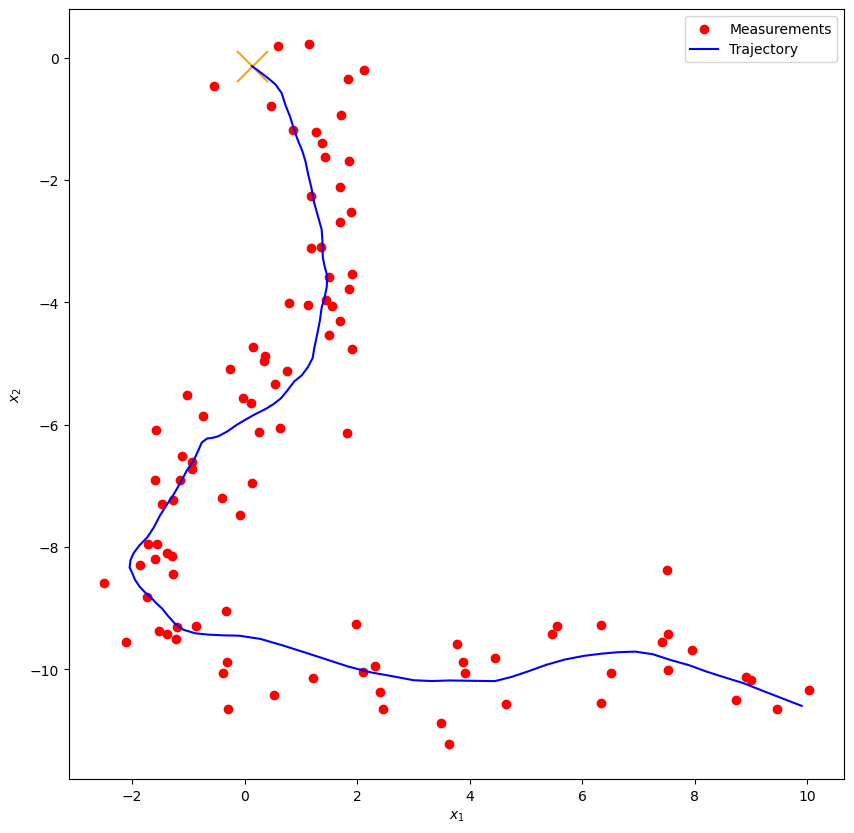

In [11]:
# This is simulation
#random_state = RandomState(6)
#steps = 100
#states, observations = generate_ssm(x_0, A, Q, H, R, steps, random_state)

# This loads stored data from file
with open("car_track.json") as fp:
    jsondata = json.load(fp)
    states = np.array(jsondata["X"]).T
    observations = np.array(jsondata["Y"]).T
    steps = states.shape[0]

plot_car_trajectory(observations, states, "Trajectory")

## Kalman Filter

In [12]:
def kalman_filter(m_0, P_0, A, Q, H, R, observations):
    M = m_0.shape[-1]
    steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0
    P = P_0
    
    for i in range(steps):
        y = observations[i]
        m = A @ m
        P = A @ P @ A.T + Q
        
        S = H @ P @ H.T + R
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        K = linalg.solve(S.T, H @ P, assume_a="pos").T 
        
        m = m + K @ (y - H @ m)
        P = P - K @ S @ K.T
        
        kf_m[i] = m
        kf_P[i] = P
    return kf_m, kf_P

RAW RMSE: 0.7679855237247215
KF RMSE: 0.4253824660526518


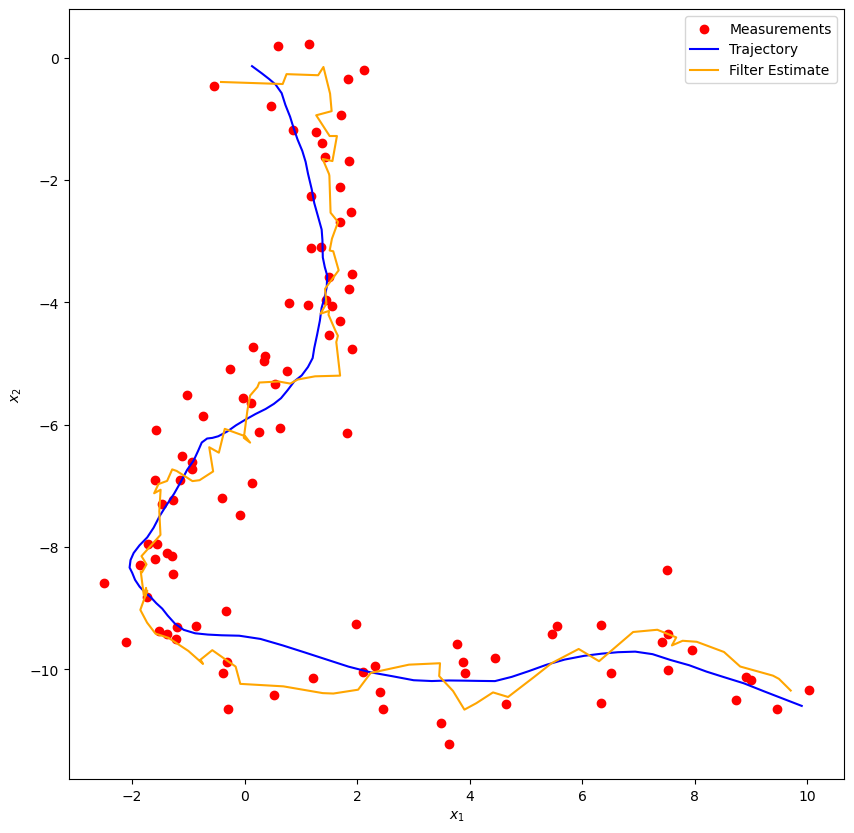

In [13]:
m_0 = x_0
P_0 = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

kf_m, kf_P = kalman_filter(m_0, P_0, A, Q, H, R, observations)

plot_car_trajectory(observations, states, "Trajectory", kf_m, "Filter Estimate")

rmse_raw = rmse(states[:, :2], observations)
rmse_kf = rmse(kf_m[:, :2], states[:, :2])
print(f"RAW RMSE: {rmse_raw}")
print(f"KF RMSE: {rmse_kf}")

## RTS Smoother

In [14]:
def rts_smoother(kf_m, kf_P, A, Q):
    steps, M = kf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = kf_m[-1]
    P = kf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    for i in range(steps-2, -1, -1):
        filtered_m = kf_m[i]
        filtered_P = kf_P[i]
        
        mp = A @ filtered_m
        Pp = A @ filtered_P @ A.T + Q

        # More efficient and stable way of computing Gk = filtered_P @ A.T @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")
        Gk = linalg.solve(Pp, A @ filtered_P, assume_a="pos").T 

        m = filtered_m + Gk @ (m - mp)
        P = filtered_P + Gk @ (P - Pp) @ Gk.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P

RTS RMSE: 0.26497104638205465


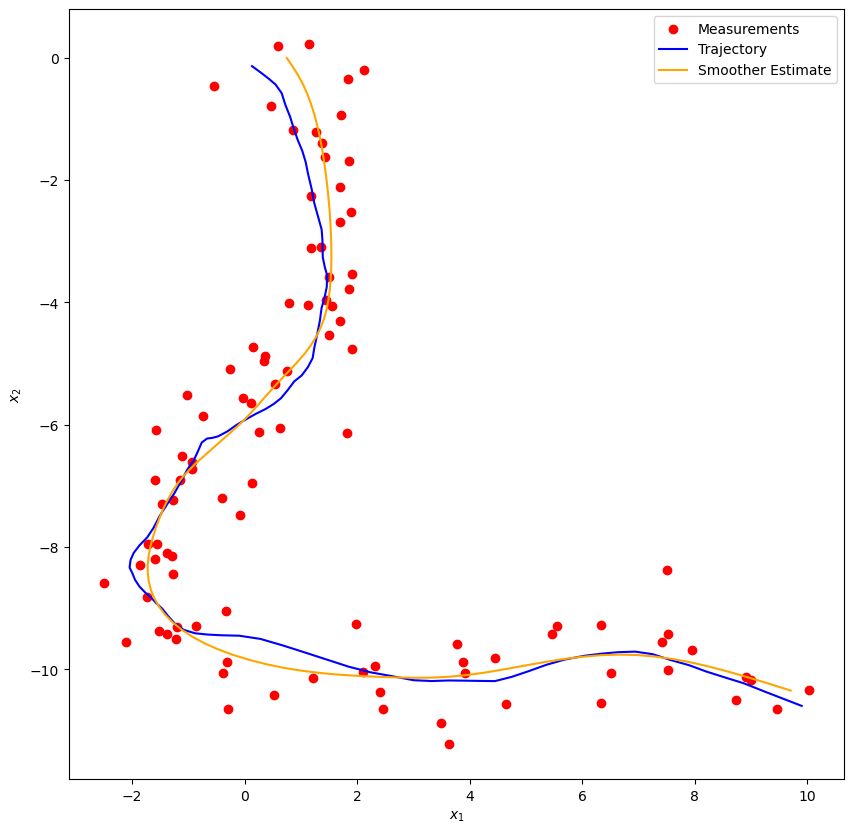

In [15]:
rts_m, rts_P = rts_smoother(kf_m, kf_P, A, Q)

plot_car_trajectory(observations, states, "Trajectory", rts_m, "Smoother Estimate")

rmse_rts = rmse(states[:, :2], rts_m[:, :2])
print(f"RTS RMSE: {rmse_rts}")

In [38]:
dt = 0.1
A = np.array([[1, 0, dt,  0],
              [0, 1,  0, dt],
              [0, 0,  1,  0],
              [0, 0,  0,  1]])
x0 = np.array([0, 0, 1, 0.5])
steps = 100

def true_states_generate(x0, A, steps):
    x = np.zeros((steps, len(x0)))
    x[0] = x0
    for i in range(1, steps):
        x[i] = A @ x[i - 1]
    return x

true_states = true_states_generate(x0, A, steps)

threshold = 1.5

def delta_trigger(observations, threshold):
    
    #creating an output array with NaNs for the skipped steps
    masked_obs = np.full_like(observations, np.nan)
    
    #List of time indices where the trigger occurs
    trigger_indices = []

    last_sent = observations[0]
    masked_obs[0] = last_sent
    trigger_indices.append(0)
    
    for t in range (1, len(observations)): 
        dist = np.linalg.norm(observations[t] - last_sent)
        if dist> threshold:
            masked_obs[t] = observations[t]
            trigger_indices.append(t)
            last_sent = observations[t]
    
    return masked_obs, trigger_indices
    
#threshold = 1.5
filtered_obs, triggered_steps = delta_trigger(observations, threshold)
valid = ~np.isnan(filtered_obs[:, 0])
triggered_points = filtered_obs[valid]

valid_delta = ~np.isnan(filtered_obs[:, 0])
triggered_coords = filtered_obs[valid_delta]

from scipy.interpolate import splprep, splev
from scipy.interpolate import interp1d

time_all = np.arange(steps)
time_delt_triggered = time_all[valid_delta]
interp_x = interp1d(time_delt_triggered, triggered_coords[:, 0], kind='linear', fill_value='extrapolate')
interp_y = interp1d(time_delt_triggered, triggered_coords[:, 1], kind='linear', fill_value='extrapolate')
est_x = interp_x(time_all)
est_y = interp_y(time_all)
estimated_line = np.column_stack([est_x, est_y])

if len(triggered_points) >= 4:
    # Prepare spline fit
    tck, _ = splprep([triggered_points[:, 0], triggered_points[:, 1]], s=15)
    u_fine = np.linspace(0, 1, 300)
    x_smooth, y_smooth = splev(u_fine, tck)
    smooth_traj = np.column_stack([x_smooth, y_smooth])
else:
    smooth_traj = triggered_points  # fallback if not enough points


valid = ~np.isnan(filtered_obs[:, 0])

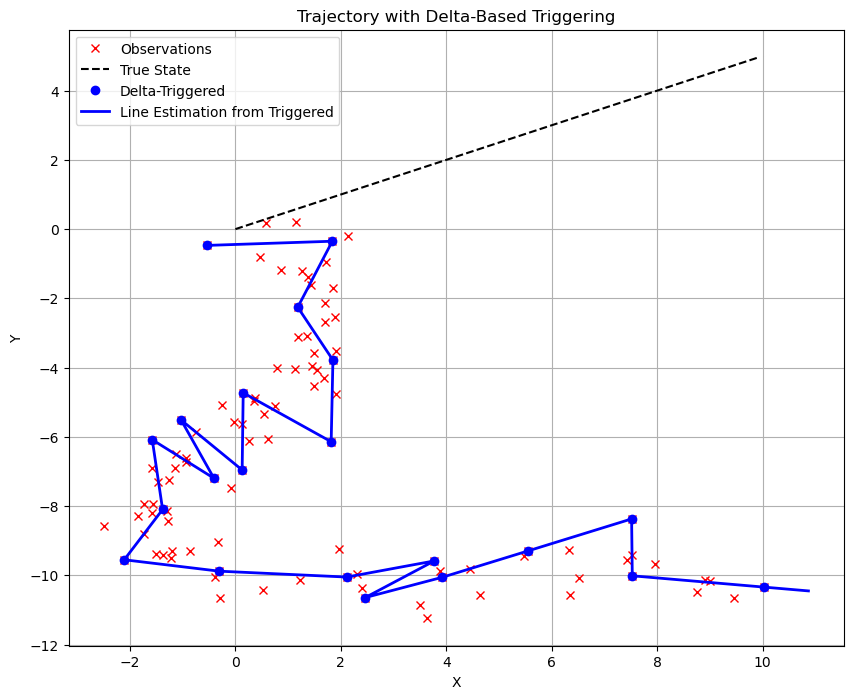

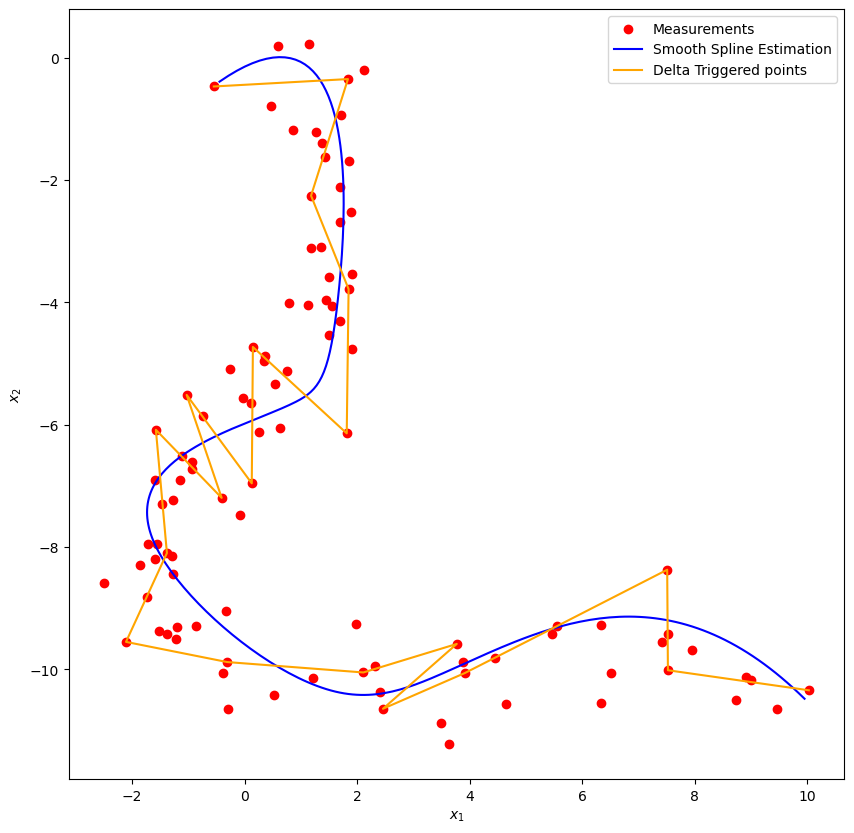

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(observations[:, 0], observations[:, 1], 'rx', label='Observations')           # all raw observations
plt.plot(true_states[:, 0], true_states[:, 1], 'k--', label='True State')              # true state path
plt.plot(filtered_obs[valid, 0], filtered_obs[valid, 1], 'bo', label='Delta-Triggered')  # triggered observations
plt.plot(est_x, est_y, 'b-', linewidth=2, label='Line Estimation from Triggered')
plt.title("Trajectory with Delta-Based Triggering")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

#plot_car_trajectory(
#    y=observations,
#    x1=estimated_line,
#    label1="Line Estimation from Triggered"
#)


plot_car_trajectory(
    y = observations,
    
    x1 = smooth_traj,
    label1 = "Smooth Spline Estimation",
    
    x2 = triggered_points,
    label2 = "Delta Triggered points"
    
)

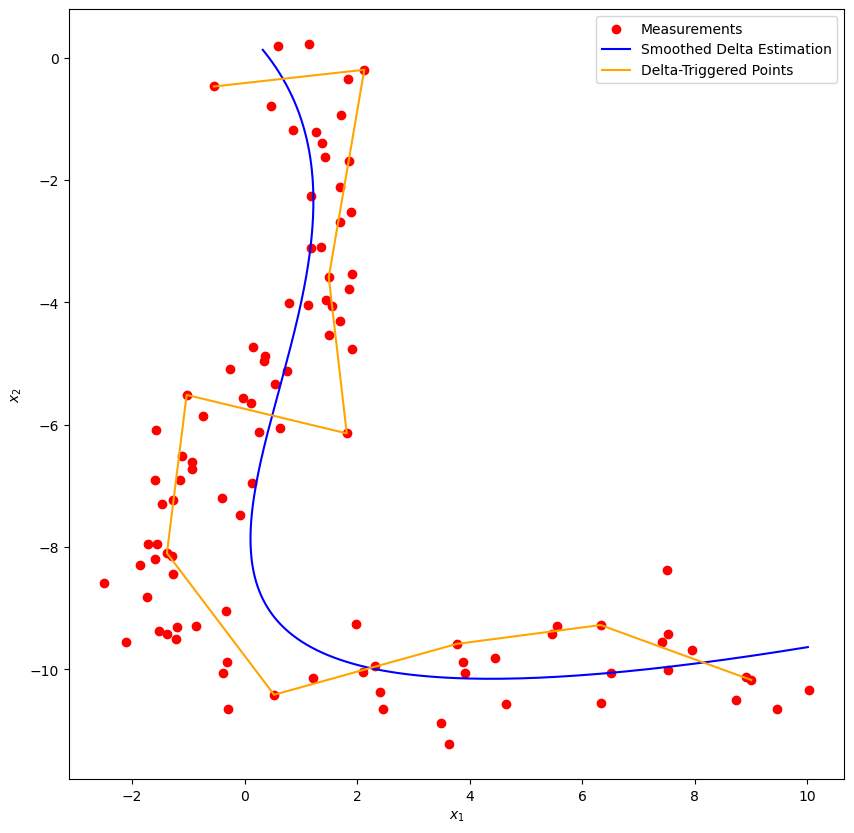

In [35]:
plot_car_trajectory(
    y=observations,
    x1=smooth_traj,              # blue smoothed trajectory
    label1="Smoothed Delta Estimation",
    x2=triggered_points,         # orange triggered points (optional)
    label2="Delta-Triggered Points"
)